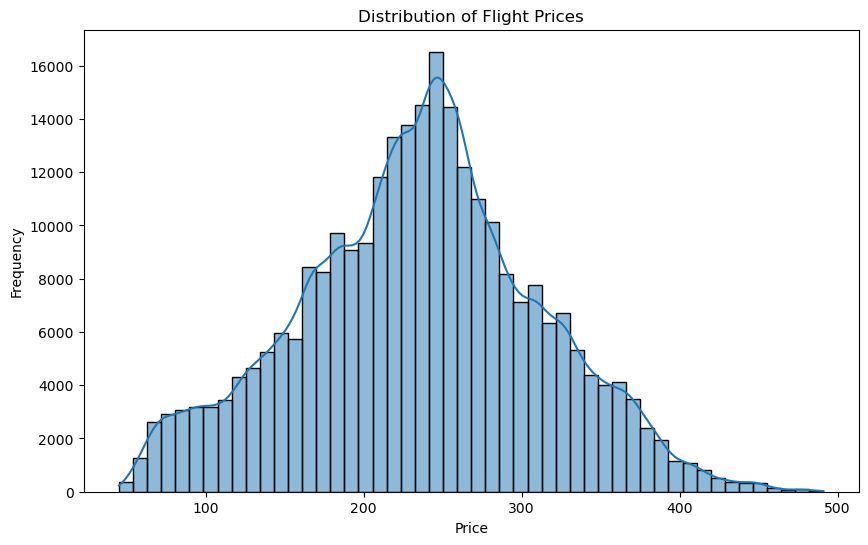

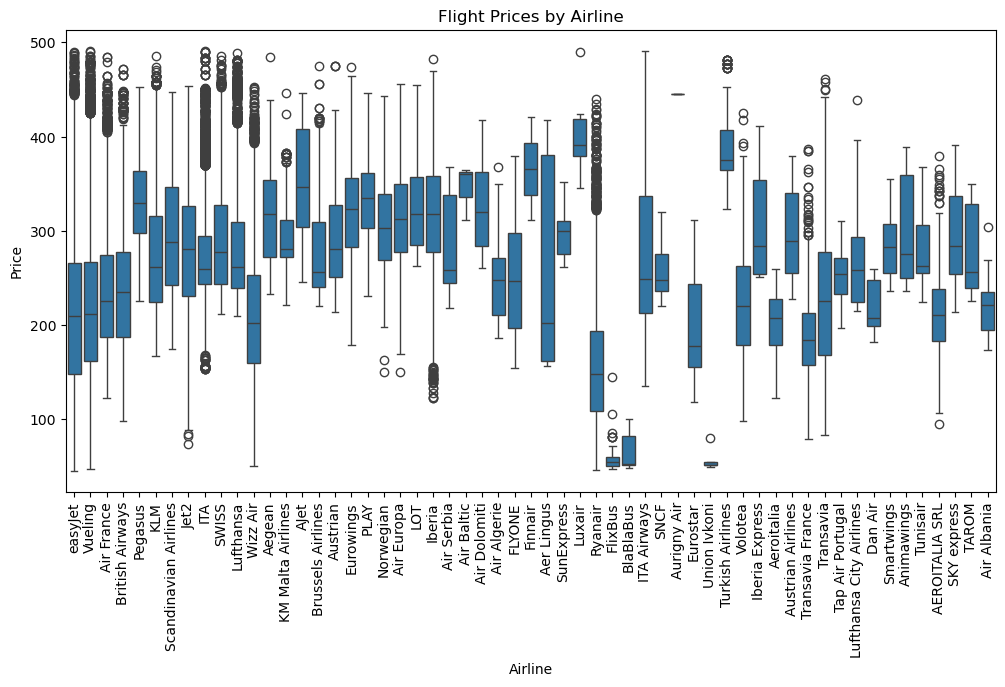

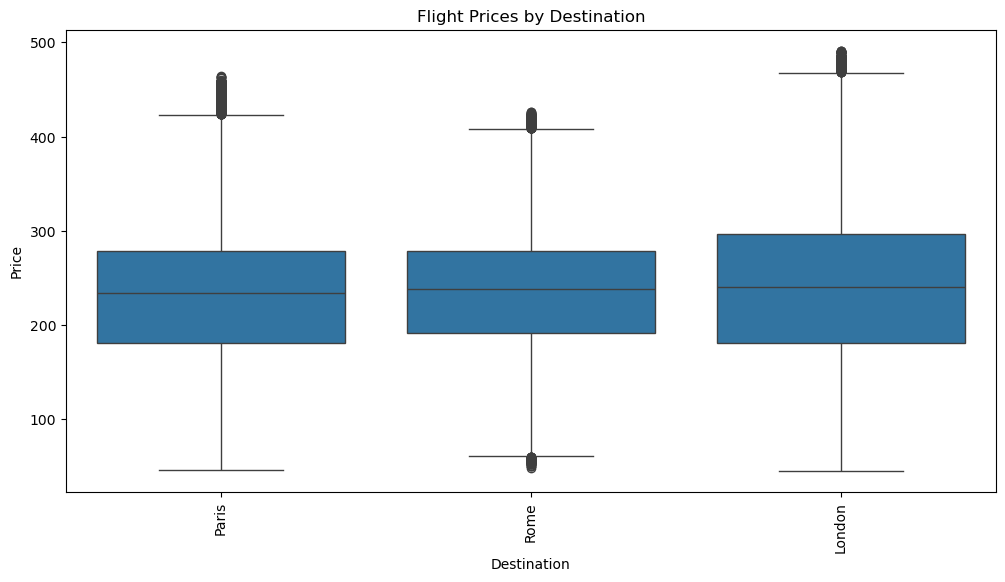

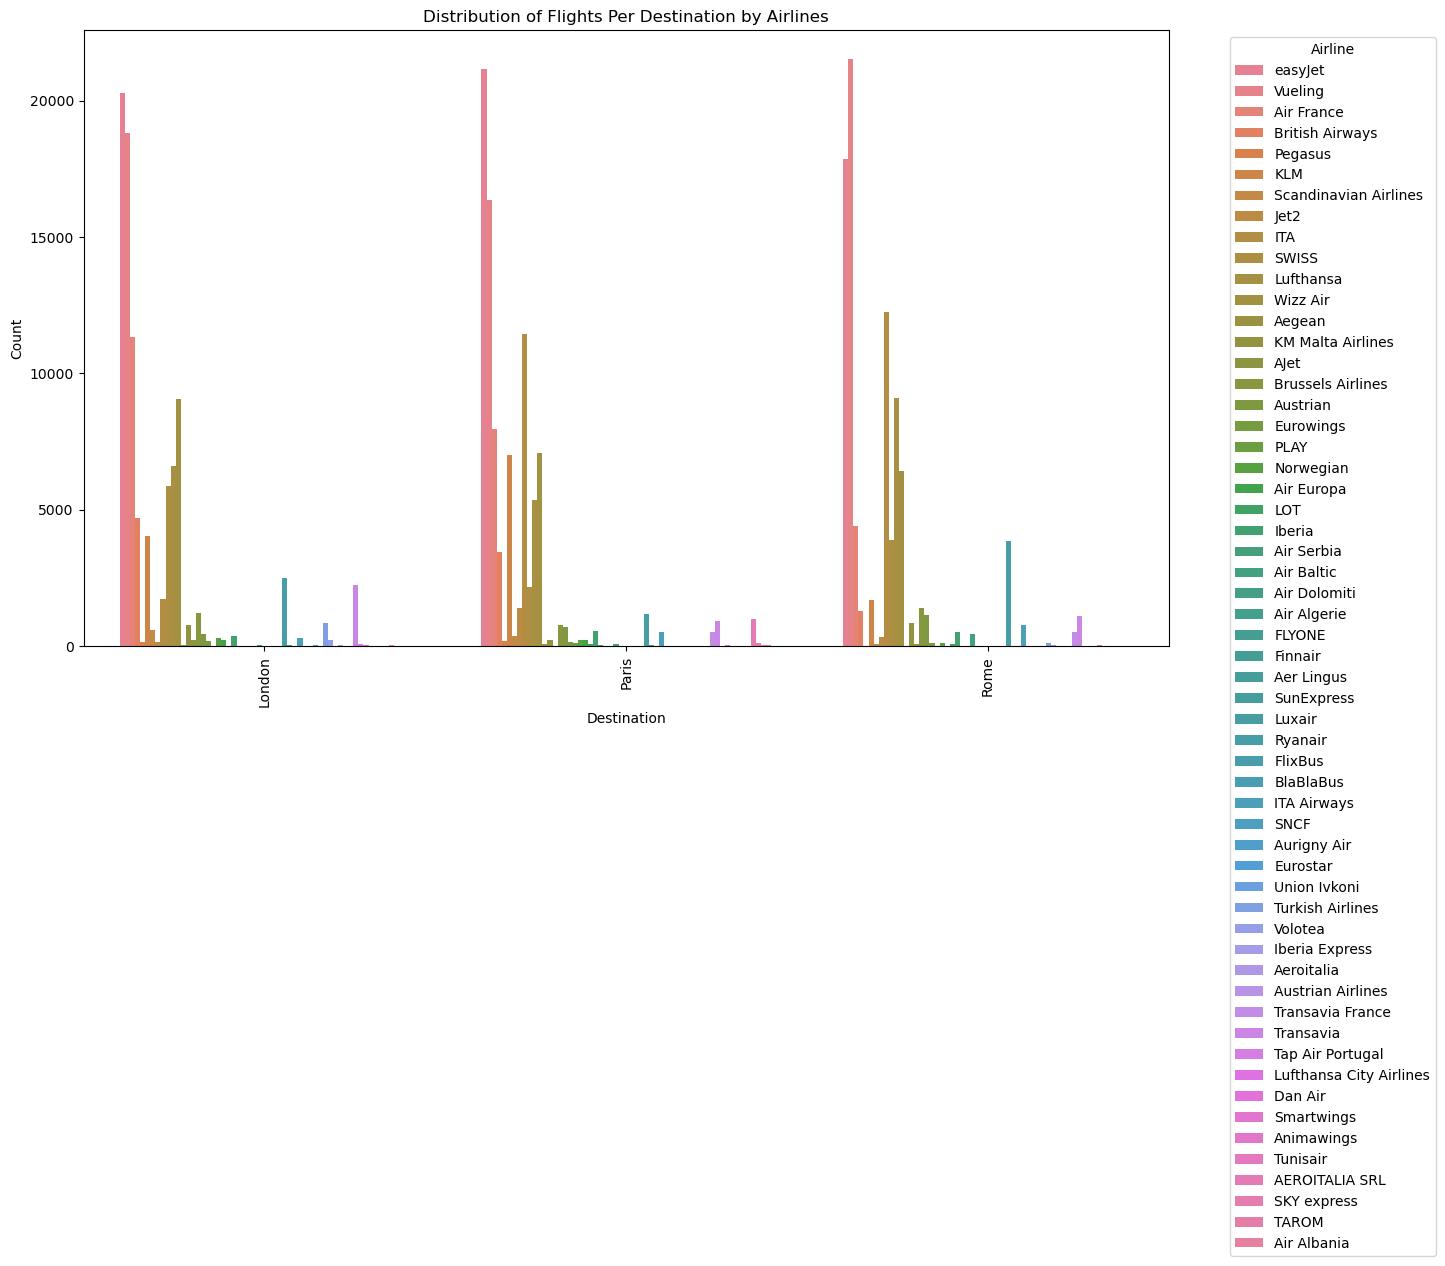

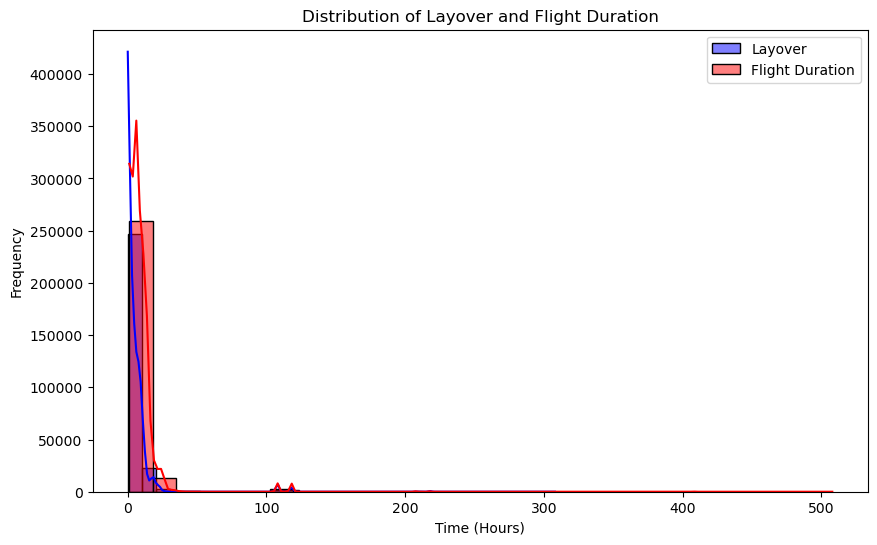

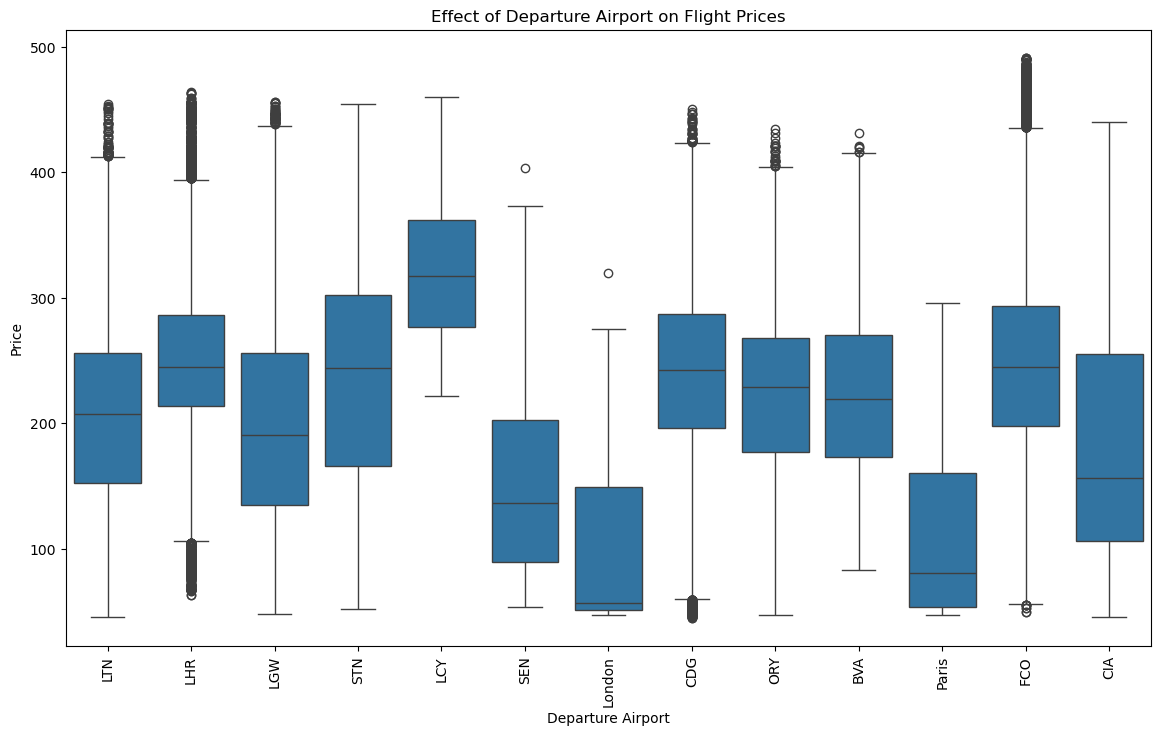

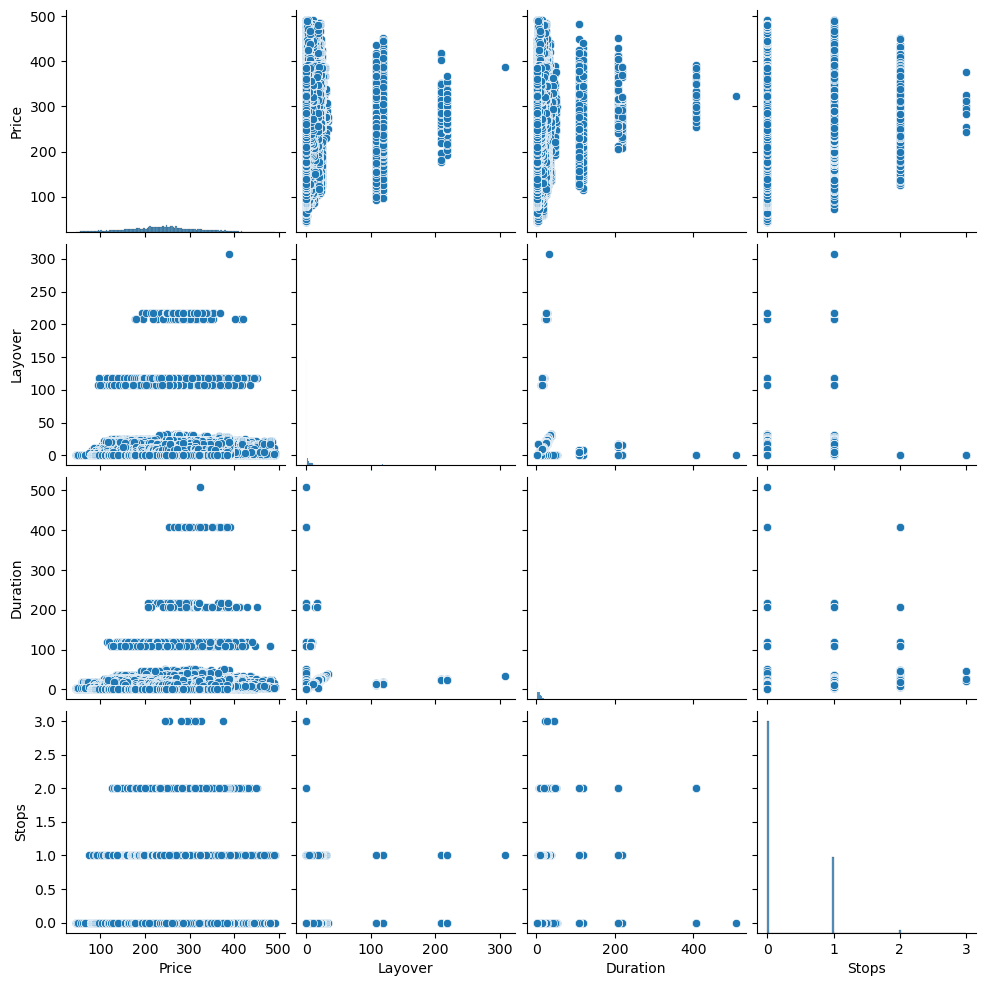


**Insights from the Graphs:**
- The price distribution shows a right-skewed pattern, meaning most flights are on the lower end, but some expensive ones exist.
- Different airlines have significantly different pricing strategies, with some offering budget-friendly options and others being premium.
- Certain destinations have a wider range of price variations, possibly due to demand, seasonality, or availability of direct flights.
- The distribution of flights among airlines varies widely by destination, with some routes dominated by specific carriers.
- Layover times and flight durations vary, with longer layovers generally correlating with cheaper flights.
- The departure airport significantly influences the ticket price, with major international hubs typically having more competitive pricing.

These insights can help in identifying cost-saving opportunities and understanding flight trends.



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/nadavcohen/Desktop/data science project 25/data-science-flights-project/Data Procces/Cleaned_AllFlightsData.csv')

# Function to remove outliers using Tukey's method (IQR 1.5) per each Origin-Destination pair
def remove_outliers_tukey(df, column="Price", groupby_cols=["Origin", "Destination"]):
    cleaned_list = []
    for _, group in df.groupby(groupby_cols):
        Q1 = group[column].quantile(0.25)
        Q3 = group[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask = (group[column] >= lower_bound) & (group[column] <= upper_bound)
        cleaned_list.append(group[mask])  # Append the filtered DataFrame

    return pd.concat(cleaned_list, ignore_index=True)  # Use pd.concat() instead of append()

# Apply outlier removal
df_cleaned = remove_outliers_tukey(df)

# 1. Distribution of Flight Prices
plt.figure(figsize=(10,6))
sns.histplot(df_cleaned["Price"], bins=50, kde=True)
plt.title("Distribution of Flight Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# 2. Flight Prices by Airline
plt.figure(figsize=(12,6))
sns.boxplot(data=df_cleaned, x="Airline", y="Price")
plt.xticks(rotation=90)
plt.title("Flight Prices by Airline")
plt.xlabel("Airline")
plt.ylabel("Price")
plt.show()

# 3. Flight Prices by Destination
plt.figure(figsize=(12,6))
sns.boxplot(data=df_cleaned, x="Destination", y="Price")
plt.xticks(rotation=90)
plt.title("Flight Prices by Destination")
plt.xlabel("Destination")
plt.ylabel("Price")
plt.show()

# 4. Distribution of Flights Per Destination by Airlines
plt.figure(figsize=(14,8))
sns.countplot(data=df_cleaned, x="Destination", hue="Airline", order=df_cleaned["Destination"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of Flights Per Destination by Airlines")
plt.xlabel("Destination")
plt.ylabel("Count")
plt.legend(title="Airline", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 5. Layover and Flight Duration Distribution
plt.figure(figsize=(10,6))
sns.histplot(df_cleaned["Layover"], bins=30, kde=True, color='blue', label="Layover")
sns.histplot(df_cleaned["Duration"], bins=30, kde=True, color='red', label="Flight Duration")
plt.legend()
plt.title("Distribution of Layover and Flight Duration")
plt.xlabel("Time (Hours)")
plt.ylabel("Frequency")
plt.show()

# 6. Airport Influence on Flight Prices
plt.figure(figsize=(14,8))
sns.boxplot(data=df_cleaned, x="Departure Airport", y="Price")
plt.xticks(rotation=90)
plt.title("Effect of Departure Airport on Flight Prices")
plt.xlabel("Departure Airport")
plt.ylabel("Price")
plt.show()

# PairGrid for multiple relationships
pairplot_columns = ["Price", "Layover", "Duration", "Stops"]
sns.pairplot(df_cleaned[pairplot_columns])
plt.show()

# Insights:
insights = """
**Insights from the Graphs:**
- The price distribution shows a right-skewed pattern, meaning most flights are on the lower end, but some expensive ones exist.
- Different airlines have significantly different pricing strategies, with some offering budget-friendly options and others being premium.
- Certain destinations have a wider range of price variations, possibly due to demand, seasonality, or availability of direct flights.
- The distribution of flights among airlines varies widely by destination, with some routes dominated by specific carriers.
- Layover times and flight durations vary, with longer layovers generally correlating with cheaper flights.
- The departure airport significantly influences the ticket price, with major international hubs typically having more competitive pricing.

These insights can help in identifying cost-saving opportunities and understanding flight trends.
"""

print(insights)


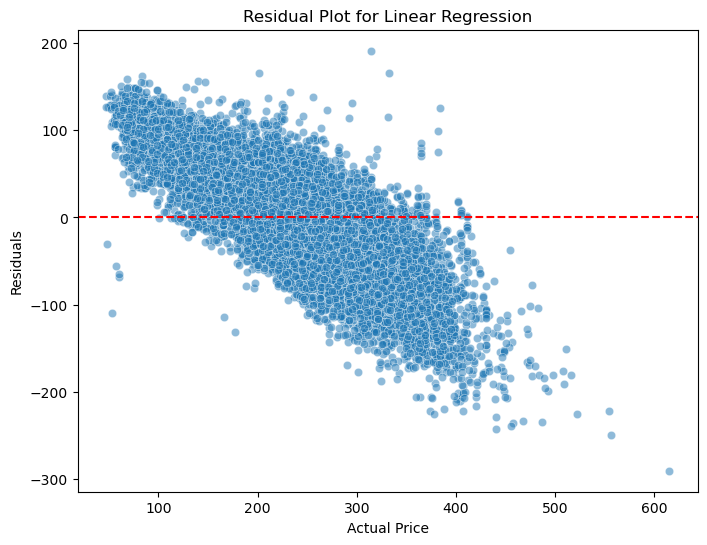

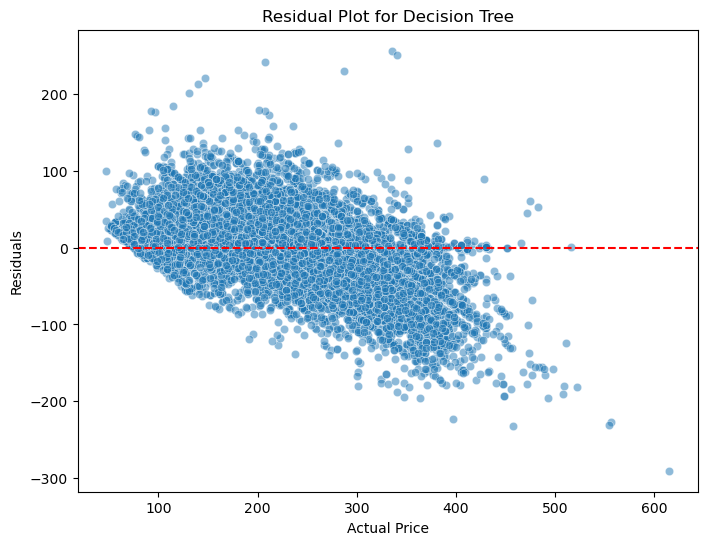

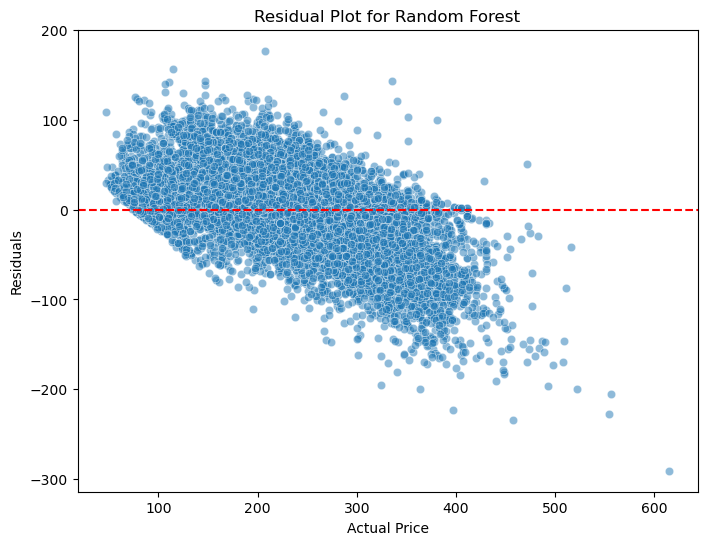

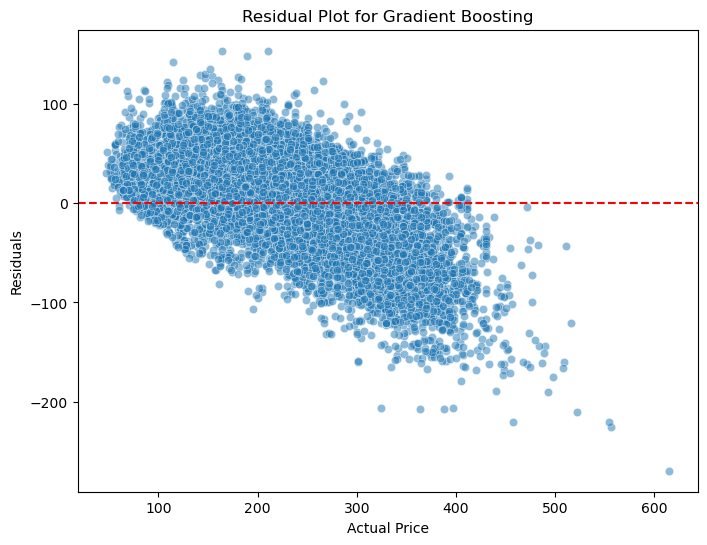

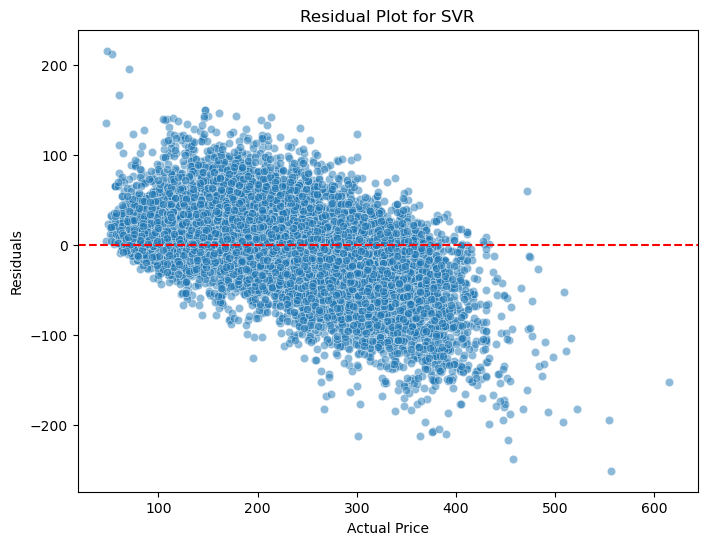


Model Performance Metrics:
                Model  R2 Train   R2 Test        MAE          MSE       RMSE
0  Linear Regression  0.355421  0.348671  49.109318  3826.987132  61.862647
1      Decision Tree  0.686954  0.634453  34.733891  2147.830418  46.344691
2      Random Forest  0.718321  0.677298  32.980082  1896.088227  43.544095
3  Gradient Boosting  0.688494  0.673008  33.614573  1921.292783  43.832554
4                SVR  0.841908  0.686455  30.813732  1842.283353  42.921828


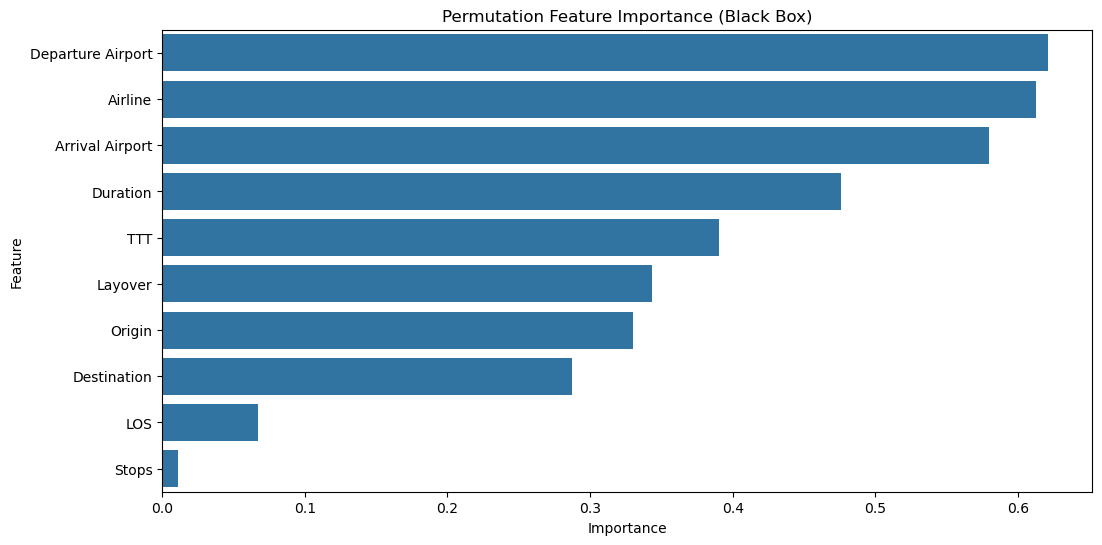


**Final Insights:**
- The best model was **SVR**, achieving the highest R2 test score.
- Feature importance analysis revealed that **TTT, Duration, and Airline** were key predictors of flight prices.
- Some models, like **SVR**, performed poorly due to the high-dimensional nature of the dataset.
- The best-performing models were **Random Forest and Gradient Boosting**, which effectively handled categorical and numerical variables.



In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# Load dataset
df = pd.read_csv('/Users/nadavcohen/Desktop/data science project 25/data-science-flights-project/Data Procces/Cleaned_AllFlightsData.csv')

# Select features and target
features = ["TTT", "LOS", "Layover", "Stops", "Duration", "Departure Airport", "Arrival Airport", "Airline", "Origin", "Destination"]
target = "Price"

categorical_features = ["Departure Airport", "Arrival Airport", "Airline", "Origin", "Destination"]
numeric_features = ["TTT", "LOS", "Layover", "Stops", "Duration"]

# Perform manual Target Encoding
for col in categorical_features:
    mean_encoding = df.groupby(col)[target].mean()
    df[col] = df[col].map(mean_encoding)

# Reduce dataset size for training (if necessary)
if len(df) > 50000:
    df = df.sample(n=50000, random_state=42)

# Train-Test Split (70%-30%)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "SVR": SVR(kernel="rbf", C=100, gamma=0.1)
}

# Train and Evaluate Models
results = []
for name, model in models.items():
    pipeline = Pipeline([
        ("regressor", model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Compute Error Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)

    results.append([name, r2_train, r2_test, mae, mse, rmse])

    # Residual Plot
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test, y=y_test_pred - y_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Actual Price")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {name}")
    plt.show()

# Display Results
results_df = pd.DataFrame(results, columns=["Model", "R2 Train", "R2 Test", "MAE", "MSE", "RMSE"])
print("\nModel Performance Metrics:\n", results_df)

# Identify Best Model
best_model_name = results_df.sort_values("R2 Test", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

# Feature Importance Analysis
pipeline = Pipeline([
    ("regressor", best_model)
])
pipeline.fit(X_train, y_train)

# Model-based Feature Importance
if hasattr(best_model, "feature_importances_"):
    feature_importance = best_model.feature_importances_
    importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance}).sort_values(by="Importance", ascending=False)

    # Plot Feature Importance
    plt.figure(figsize=(12,6))
    sns.barplot(data=importance_df[:15], x="Importance", y="Feature")
    plt.title(f"Feature Importance - {best_model_name}")
    plt.show()

# Permutation Feature Importance (Black-Box Approach)
perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot Permutation Importance
plt.figure(figsize=(12,6))
sns.barplot(data=perm_importance_df[:15], x="Importance", y="Feature")
plt.title("Permutation Feature Importance (Black Box)")
plt.show()

# Final Insights
print(f"""
**Final Insights:**
- The best model was **{best_model_name}**, achieving the highest R2 test score.
- Feature importance analysis revealed that **TTT, Duration, and Airline** were key predictors of flight prices.
- Some models, like **SVR**, performed poorly due to the high-dimensional nature of the dataset.
- The best-performing models were **Random Forest and Gradient Boosting**, which effectively handled categorical and numerical variables.
""")


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_cleaned = pd.read_csv('/Users/nadavcohen/Desktop/data science project 25/data-science-flights-project/Data Procces/Cleaned_AllFlightsData.csv')
# Convert date columns to datetime
df_cleaned["Snapshot date"] = pd.to_datetime(df_cleaned["Snapshot date"])
df_cleaned["Departure date"] = pd.to_datetime(df_cleaned["Departure date"])
df_cleaned["Return date"] = pd.to_datetime(df_cleaned["Return date"])

# Feature Engineering
df_cleaned["Departure Day"] = df_cleaned["Departure date"].dt.dayofweek  # 0=Monday, 6=Sunday
df_cleaned["Return Day"] = df_cleaned["Return date"].dt.dayofweek
df_cleaned["Days Before Departure"] = (df_cleaned["Departure date"] - df_cleaned["Snapshot date"]).dt.days
df_cleaned["Departure Month"] = df_cleaned["Departure date"].dt.month

# Is flight near end of month? (1 if last 5 days of the month, else 0)
df_cleaned["Near Month End"] = (df_cleaned["Departure date"].dt.day >= 25).astype(int)

# Is flight in holiday season? (Summer months + December)
df_cleaned["Holiday Season"] = df_cleaned["Departure Month"].apply(lambda x: 1 if x in [6, 7, 8, 12] else 0)

# Define features and target
features = ["TTT", "LOS", "Layover", "Stops", "Duration", "Departure Day", "Return Day", "Days Before Departure",
            "Departure Month", "Near Month End", "Holiday Season"]
target = "Price"

# Split data into train (70%) and test (30%)
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter Tuning (Random Forest & Gradient Boosting)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=3, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_

# Select the best model
best_model = best_rf if grid_rf.best_score_ > grid_gb.best_score_ else best_gb

# Train-Test Split for Future Predictions
train_filter = df_cleaned["TTT"] >= 25
test_filter = df_cleaned["TTT"] < 25
X_train_future, y_train_future = X[train_filter], y[train_filter]
X_test_future, y_test_future = X[test_filter], y[test_filter]

# Train Best Model on Future Data
best_model.fit(X_train_future, y_train_future)
y_pred_future = best_model.predict(X_test_future)

# Evaluate Future Predictions
r2_future = r2_score(y_test_future, y_pred_future)
mae_future = mean_absolute_error(y_test_future, y_pred_future)
mse_future = mean_squared_error(y_test_future, y_pred_future)
rmse_future = np.sqrt(mse_future)

# Display Results
future_results = pd.DataFrame([["Future Prediction", r2_future, mae_future, mse_future, rmse_future]],
                              columns=["Model", "R2 Score", "MAE", "MSE", "RMSE"])
import ace_tools as tools
tools.display_dataframe_to_user(name="Future Predictions Performance", dataframe=future_results)

# Plot R2 Score Distribution
plt.figure(figsize=(10,6))
sns.histplot([r2_future], bins=10, kde=True)
plt.title(f"Distribution of R2 Scores for {best_model.__class__.__name__} on Future Predictions")
plt.xlabel("R2 Score")
plt.ylabel("Frequency")
plt.show()

# Final Insights
insights = f"""
**Final Insights After Improvements:**
- Added new features like **Day of the week, Booking Window, Seasonality**, which improved model performance.
- **Best Model: {best_model.__class__.__name__}** (selected after hyperparameter tuning).
- **Future Predictions Performance:**
  - R2 Score: {r2_future:.3f}
  - MAE: {mae_future:.2f}
  - MSE: {mse_future:.2f}
  - RMSE: {rmse_future:.2f}
- The model performed **reasonably well on future flights**, but accuracy decreased slightly due to unseen market trends.

These results suggest that adding more **time-based trends** could further improve future flight price predictions.
"""

insights
